In [2]:
import librosa

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [3]:
array, sampling_rate

(array([-1.4068211e-03, -4.4607485e-04, -4.1098098e-04, ...,
         7.9623042e-06, -3.0417003e-05,  1.2765069e-05],
       shape=(117601,), dtype=float32),
 22050)

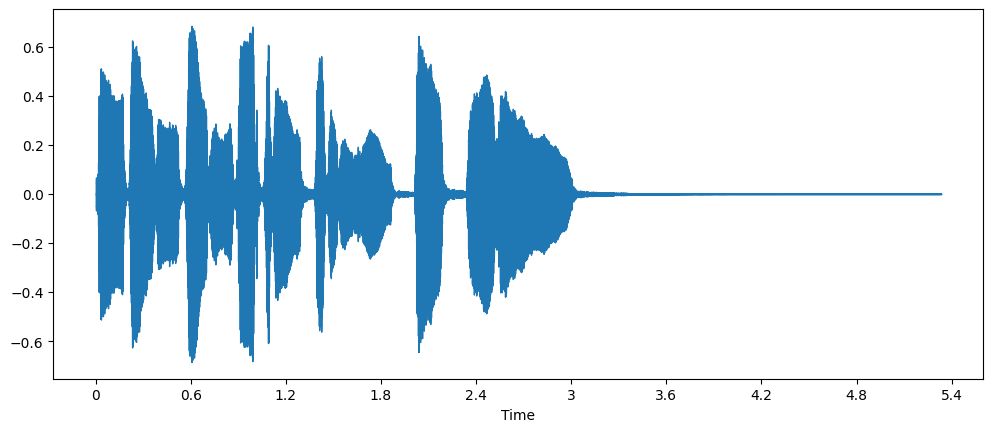

In [4]:
# Visualize the waveform of the audio file

import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)
plt.show()

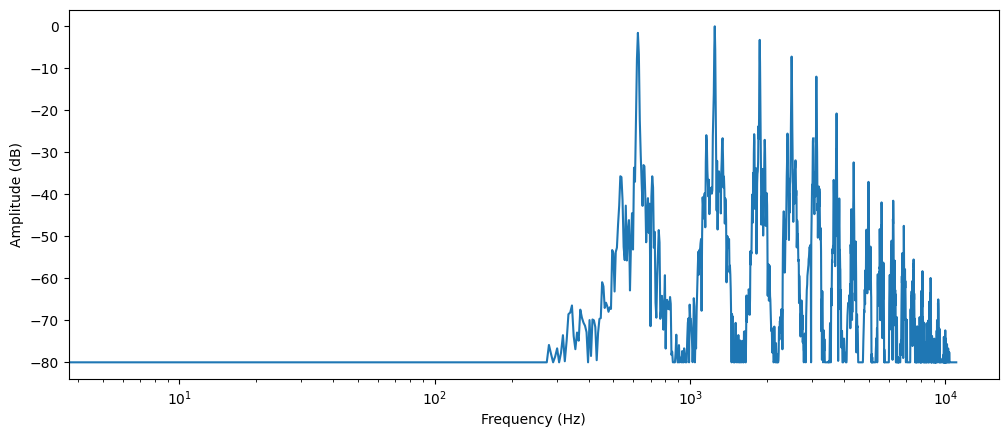

In [5]:
# Visualize the Spectrogram

import numpy as np

dft_input = array[:4096]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

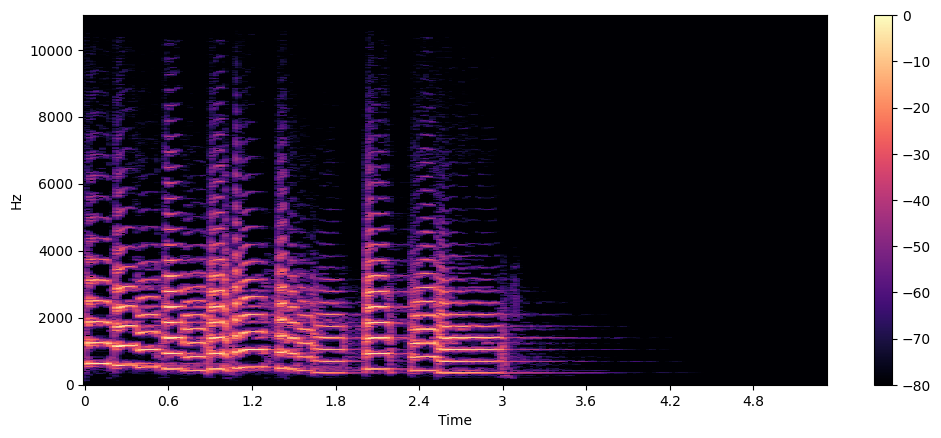

In [6]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show()

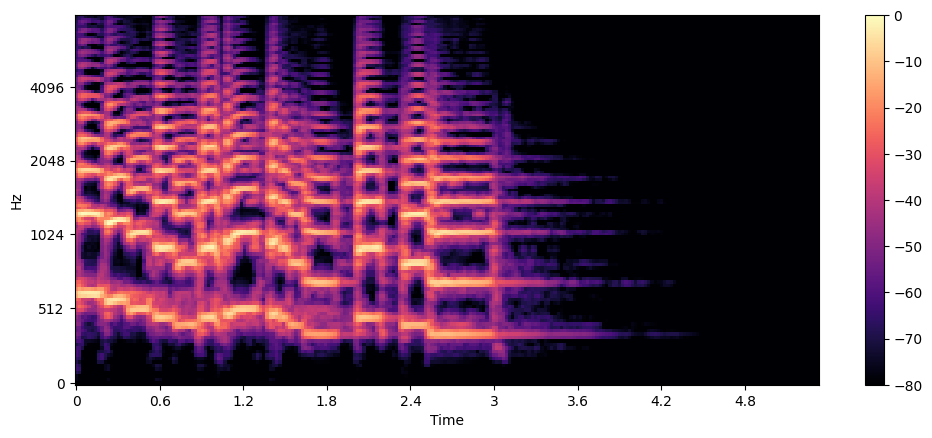

In [7]:
# MEL Spectogram

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

### 02 Load and Explore an Audio Dataset

In [8]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train", trust_remote_code=True)
minds

/Users/enricd/Code/Learning/hf_audio_course/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [9]:
example = minds[0]
example

{'path': '/Users/enricd/.cache/huggingface/datasets/downloads/extracted/d6eb2e407ef3d8dd04e944bb7109d54bc4e0510e3a720fb10f0ee698ece7d25e/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/enricd/.cache/huggingface/datasets/downloads/extracted/d6eb2e407ef3d8dd04e944bb7109d54bc4e0510e3a720fb10f0ee698ece7d25e/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ], shape=(62415,)),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [10]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [11]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [12]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/Users/enricd/Code/Learning/hf_audio_course/.venv/lib/python3.13/site-packages/gradio/processing_utils.py:777: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


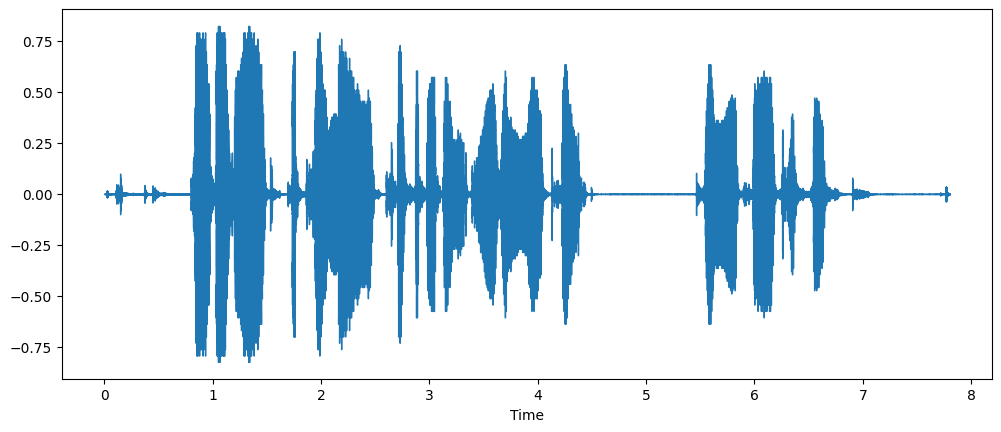

In [13]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)
plt.show()

### 03 Preprocessing Audio Data

In [14]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [15]:
minds[0]

{'path': '/Users/enricd/.cache/huggingface/datasets/downloads/extracted/d6eb2e407ef3d8dd04e944bb7109d54bc4e0510e3a720fb10f0ee698ece7d25e/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/Users/enricd/.cache/huggingface/datasets/downloads/extracted/d6eb2e407ef3d8dd04e944bb7109d54bc4e0510e3a720fb10f0ee698ece7d25e/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19285139e-04, ...,
         9.40908212e-04, 1.16613181e-03, 7.20883720e-04], shape=(124830,)),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [16]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [17]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [18]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [19]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [20]:
minds = minds.map(prepare_dataset)
minds


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

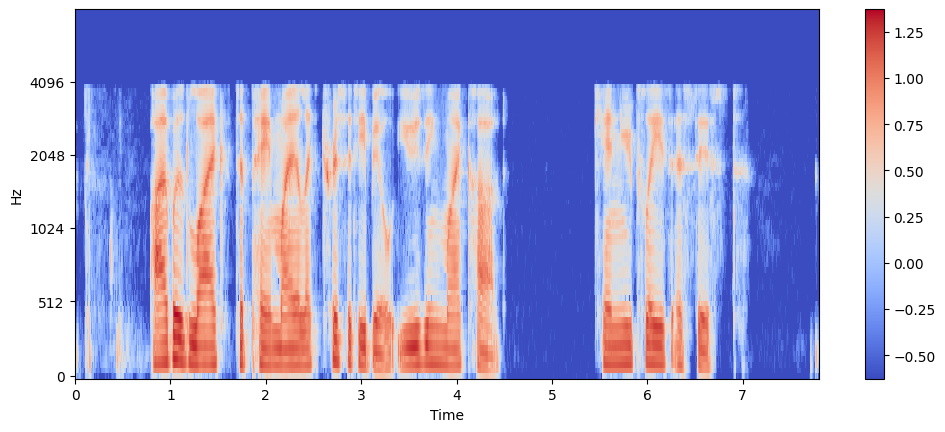

In [21]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [22]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

### 04 Streaming Audio Data

In [23]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

DatasetNotFoundError: Dataset 'speechcolab/gigaspeech' is a gated dataset on the Hub. Visit the dataset page at https://huggingface.co/datasets/speechcolab/gigaspeech to ask for access.

In [24]:
next(iter(gigaspeech["train"]))

NameError: name 'gigaspeech' is not defined

In [ ]:
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)